<a href="https://colab.research.google.com/github/Nafis2605/COVID-19-Patient-Detection-with-Chest-X-Ray/blob/master/COVID_19_Patient_Detection_with_Chest_X_Ray.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing  Necessary Libraries 

In [ ]:
import os
import shutil
import random
import torch
import torchvision
import numpy as np

from PIL import Image
from matplotlib import pyplot as plt
%matplotlib inline

torch.manual_seed(0)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Training Dataset and Test Dataset Preparation
 

In [2]:
root_dir = '/content/drive/My Drive/Colab Notebooks/ML Project/COVID-19 Radiography Database'
image_dir = ['NORMAL', 'Viral Pneumonia', 'COVID-19']
class_names = ['normal', 'viral', 'covid']


if os.path.isdir(os.path.join(root_dir, image_dir[1])):
    os.mkdir(os.path.join(root_dir, 'test'))
    #Creating Test Folder           

    for i, d in enumerate(image_dir):
        os.rename(os.path.join(root_dir, d), os.path.join(root_dir, class_names[i]))
        #Changing the name of the folders according to the class names

    for name in class_names:
        os.mkdir(os.path.join(root_dir, 'test', name))
        #Creating Sub Folders according to the class names in the test folder

    for name in class_names:
        images = [x for x in os.listdir(os.path.join(root_dir, name)) if  x[-3:].lower().endswith('png')]
        selected_images = random.sample(images, 30)
        #Randomly Selecting 30 Images from each type folder
        
        for image in selected_images:
            source_folder = os.path.join(root_dir, name, image)
            target_folder = os.path.join(root_dir, 'test', name, image)
            shutil.move(source_folder, target_folder)
            #Moving Random 30 Images into the subfolders of the test folder

# Custom Dataset Preparation


In [3]:
class ChestXRayDataset(torch.utils.data.Dataset):
    def __init__(self, image_dirs, transform):
        def get_images(class_name):
            images = [x for x in os.listdir(image_dirs[class_name]) if x[-3:].lower().endswith('png')]
            print(f'Found {len(images)} {class_name} examples')
            return images
        
        self.images = {}
        self.class_names = ['normal', 'viral', 'covid']
        
        for class_name in self.class_names:
            self.images[class_name] = get_images(class_name)
            
        self.image_dirs = image_dirs
        self.transform = transform
        
    
    def __len__(self):
        return sum([len(self.images[name]) for name in self.class_names])
    
    
    def __getitem__(self, index):
        class_name = random.choice(self.class_names)
        index = index % len(self.images[class_name])
        image_name = self.images[class_name][index]
        image_path = os.path.join(self.image_dirs[class_name], image_name)
        image = Image.open(image_path).convert('RGB')
        return self.transform(image), self.class_names.index(class_name)

# Image Transformation


In [4]:
train_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224, 0.225])                                                  
])

test_transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(size=(224,224)),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229,0.224, 0.225])                                                  
])

# Data Loader Preparation

In [5]:
train_dirs={
    'normal':'/content/drive/My Drive/Colab Notebooks/Machine Learning Project/COVID-19 Radiography Database/normal',
    'viral' :'/content/drive/My Drive/Colab Notebooks/Machine Learning Project/COVID-19 Radiography Database/viral',
    'covid' :'/content/drive/My Drive/Colab Notebooks/Machine Learning Project/COVID-19 Radiography Database/covid'
}

In [7]:
train_dataset = ChestXRayDataset(train_dirs, train_transform)

Found 1281 normal examples
Found 1285 viral examples
Found 159 covid examples


In [8]:
test_dirs={
    'normal':'/content/drive/My Drive/Colab Notebooks/Machine Learning Project/COVID-19 Radiography Database/test/normal',
    'viral' :'/content/drive/My Drive/Colab Notebooks/Machine Learning Project/COVID-19 Radiography Database//test/viral',
    'covid' :'/content/drive/My Drive/Colab Notebooks/Machine Learning Project/COVID-19 Radiography Database/test/covid'
}

In [14]:
test_dataset = ChestXRayDataset(test_dirs, test_transform)

Found 30 normal examples
Found 30 viral examples
Found 30 covid examples


In [15]:
dl_train = torch.utils.data.DataLoader(train_dataset, batch_size= 6, shuffle=True)
dl_test = torch.utils.data.DataLoader(test_dataset, batch_size= 6, shuffle=True)

In [16]:
print('Number of training batches', len(dl_train))
print('Number of test batches', len(dl_test))

Number of training batches 455
Number of test batches 15


# Data Visualization

In [17]:
class_names = train_dataset.class_names


def show_images(images, labels, preds):
    plt.figure(figsize=(8, 4))
    for i, image in enumerate(images):
        plt.subplot(1, 6, i + 1, xticks=[], yticks=[])
        image = image.numpy().transpose((1, 2, 0))
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image * std + mean
        image = np.clip(image, 0., 1.)
        plt.imshow(image)
        col = 'green'
        if preds[i] != labels[i]:
            col = 'red'
            
        plt.xlabel(f'{class_names[int(labels[i].numpy())]}')
        plt.ylabel(f'{class_names[int(preds[i].numpy())]}', color=col)
    plt.tight_layout()
    plt.show()

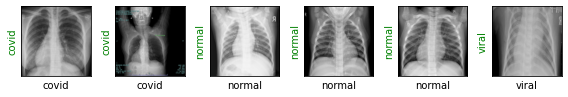

In [18]:
images, labels = next(iter(dl_train))
show_images(images, labels, labels)

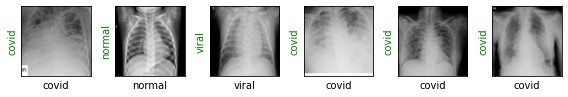

In [19]:
images, labels = next(iter(dl_test))
show_images(images, labels, labels)

# Resnet18 Model Modification
 


In [20]:
resnet18 = torchvision.models.resnet18(pretrained=True)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


In [21]:
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(resnet18.parameters(), lr=3e-5)

In [22]:
def show_preds():
    resnet18.eval()
    images, labels = next(iter(dl_test))
    outputs = resnet18(images)
    _, preds = torch.max(outputs, 1)
    show_images(images, labels, preds)

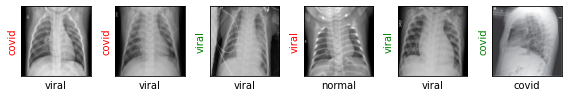

In [23]:
show_preds()

# Model Training 

In [24]:
def train(epochs):
    for e in range(0, epochs):
        print(f'Starting epoch {e + 1}/{epochs}')

        train_loss = 0.
        val_loss = 0.

        resnet18.train() # set model to training phase

        for train_step, (images, labels) in enumerate(dl_train):
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            if train_step % 10 == 0:
                print('Evaluating at step', train_step)

                accuracy = 0

                resnet18.eval() # set model to eval phase

                for val_step, (images, labels) in enumerate(dl_test):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()

                    _, preds = torch.max(outputs, 1)
                    accuracy += sum((preds == labels).numpy())

                val_loss /= (val_step + 1)
                accuracy = accuracy/len(test_dataset)
                print(f'Validation Loss: {val_loss:.4f}, Accuracy: {accuracy:.4f}')

                show_preds()

                resnet18.train()

                if accuracy >= 0.95:
                    print('Performance condition satisfied')
                    return

        train_loss /= (train_step + 1)

        print(f'Training Loss: {train_loss:.4f}')
    print('Training complete.')

Starting epoch 1/1
Evaluating at step 0
Validation Loss: 1.2349, Accuracy: 0.2333


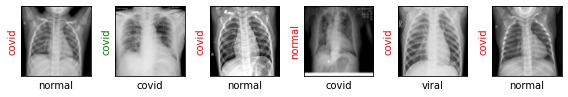

Evaluating at step 10
Validation Loss: 0.8728, Accuracy: 0.7333


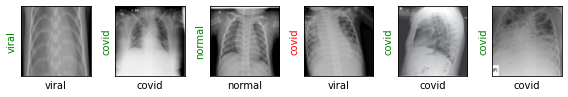

Evaluating at step 20
Validation Loss: 0.7078, Accuracy: 0.8111


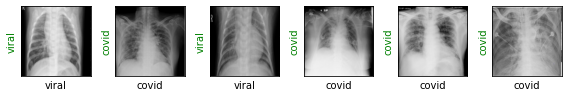

Evaluating at step 30
Validation Loss: 0.4640, Accuracy: 0.8556


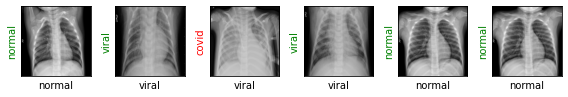

Evaluating at step 40
Validation Loss: 0.3790, Accuracy: 0.8333


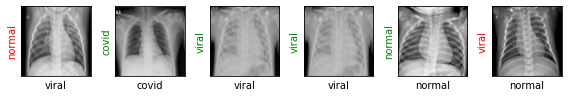

Evaluating at step 50
Validation Loss: 0.2812, Accuracy: 0.9111


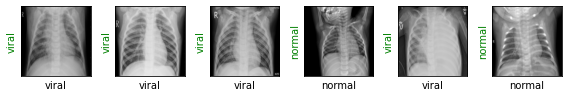

Evaluating at step 60
Validation Loss: 0.2299, Accuracy: 0.9000


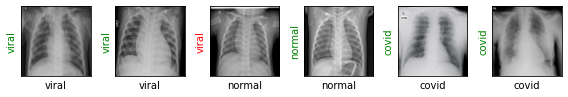

Evaluating at step 70
Validation Loss: 0.2281, Accuracy: 0.9444


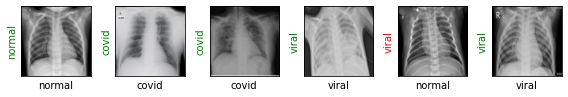

Evaluating at step 80
Validation Loss: 0.1714, Accuracy: 0.9556


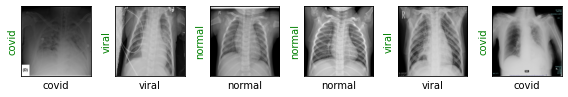

Evaluating at step 90
Validation Loss: 0.1254, Accuracy: 0.9667


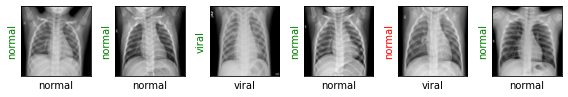

Evaluating at step 100
Validation Loss: 0.1718, Accuracy: 0.9444


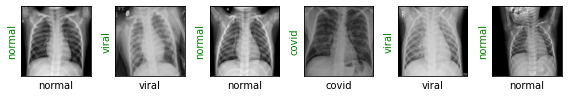

Evaluating at step 110
Validation Loss: 0.1481, Accuracy: 0.9778


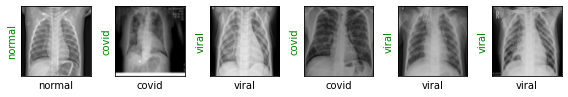

Evaluating at step 120
Validation Loss: 0.0925, Accuracy: 0.9889


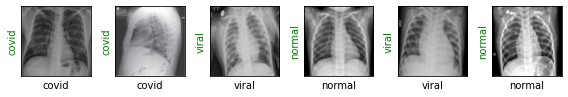

Performance condition satisfied, stopping..


In [25]:
train(epochs=1)

# Final Result

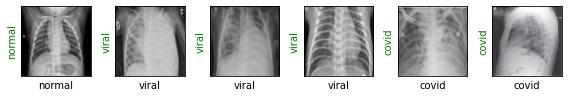

In [26]:
show_preds()